In [1]:
import re
import string
from collections import defaultdict
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import json
import dill
import random
from utils import beam_search

In [2]:

"""
Phân chia đoạn văn thành các câu đơn
"""
def split_into_sentences(paragraph):
    sentences = re.split(r'(?<!\w\.\w\.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', paragraph)
    return [sentence.strip() for sentence in sentences if sentence.strip()]


In [3]:
paragraph = "Python is amazing. It is versatile! Do you like Python?"
result = split_into_sentences(paragraph)
print(result)

['Python is amazing.', 'It is versatile!', 'Do you like Python?']


In [4]:
#Loại bỏ các dấu câu
def remove_punctuation(text):
  return "".join([char for char in text if char not in string.punctuation])

In [5]:
sentence = "Kiểm tra thử loại bỏ các dấu câu!!! Ngày mai, trời lại sáng"
remove_punctuation(sentence)

'Kiểm tra thử loại bỏ các dấu câu Ngày mai trời lại sáng'

In [6]:
def remove_punctuation_corpus(corpus):
  corpus_process = []
  for sentence in tqdm(corpus):
    corpus_process.append(remove_punctuation(sentence))
  return corpus_process

In [7]:
def remove_diacritic(text):
    """Hàm loại bỏ dấu tiếng Việt"""
    DIACRITIC_MAP = {
        "áàảãạăắằẳẵặâấầẩẫậ": "a",
        "ÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬ": "A",
        "éèẻẽẹêếềểễệ": "e",
        "ÉÈẺẼẸÊẾỀỂỄỆ": "E",
        "íìỉĩị": "i",
        "ÍÌỈĨỊ": "I",
        "óòỏõọôốồổỗộơớờởỡợ": "o",
        "ÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢ": "O",
        "úùủũụưứừửữự": "u",
        "ÚÙỦŨỤƯỨỪỬỮỰ": "U",
        "ýỳỷỹỵ": "y",
        "ÝỲỶỸỴ": "Y",
        "đ": "d",
        "Đ": "D",
    }
    for accents, char in DIACRITIC_MAP.items():
        text = re.sub(f"[{accents}]", char, text)
    return text

In [8]:
file_path = 'train_ipt_500k.pkl'
with open(file_path, 'rb') as f:
    train_ipt_500k = pickle.load(f)

In [9]:
train_ipt_500k[:10]

['Trang Chính\n',
 'Internet Society\n',
 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận, phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành. Tổ chức này chú trọng đến: tiêu chuẩn, giáo dục và các vấn đề về chính sách. Với trên 145 tổ chức thành viên và 65.000 thành viên cá nhân, ISOC bao gồm những con người cụ thể trong cộng đồng Internet. Mọi chi tiết có thể tìm thấy tại website của ISOC.\n',
 'Internet Society nằm ở gần thủ đô Washington, DC, Hoa Kỳ và Geneva, Thụy Sĩ. Số hội viên của nó bao gồm hơn 145 tổ chức thành viên và hơn 65.000 cá nhân. Thành viên còn có thể tự lập một chi nhánh của tổ chức tùy theo vị trí hoặc sở thích. Hiện nay tổ chức có tới 90 chi nhánh trên toàn thế giới.\n',
 'Bảo đảm, cổ vũ cho sự phát triển, mở rộng và sử dụng Internet được thuận lợi nhất cho mọi người trên toàn thế giới.\n',
 'Tiếng Việt\n',
 'Tiếng Việt được chính thức ghi nhận trong Hiến pháp nước Cộng hòa xã hội chủ nghĩa Việt Nam 2013, tại Chương I Điều 5

In [11]:
dataset = train_ipt_500k[:5678]
sentences_data = [sent for sentence in dataset for sent in split_into_sentences(sentence)]
#remove_punctuation_corpus(dataset)
print(sentences_data[:10])


['Trang Chính', 'Internet Society', 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận, phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành.', 'Tổ chức này chú trọng đến: tiêu chuẩn, giáo dục và các vấn đề về chính sách.', 'Với trên 145 tổ chức thành viên và 65.000 thành viên cá nhân, ISOC bao gồm những con người cụ thể trong cộng đồng Internet.', 'Mọi chi tiết có thể tìm thấy tại website của ISOC.', 'Internet Society nằm ở gần thủ đô Washington, DC, Hoa Kỳ và Geneva, Thụy Sĩ.', 'Số hội viên của nó bao gồm hơn 145 tổ chức thành viên và hơn 65.000 cá nhân.', 'Thành viên còn có thể tự lập một chi nhánh của tổ chức tùy theo vị trí hoặc sở thích.', 'Hiện nay tổ chức có tới 90 chi nhánh trên toàn thế giới.']


In [12]:
string_test = 'Những ngôn ngữ này có chung một số từ vựng căn bản. Thí dụ, từ "tay" trong tiếng Việt tương đương trong tiếng Mường là "thay", trong tiếng Khmer là "đay" và trong tiếng Môn là "tai".'

In [13]:
string_remove_diacritic = remove_diacritic(string_test)
print(string_remove_diacritic)

Nhung ngon ngu nay co chung mot so tu vung can ban. Thi du, tu "tay" trong tieng Viet tuong duong trong tieng Muong la "thay", trong tieng Khmer la "day" va trong tieng Mon la "tai".


In [14]:
print(len(sentences_data))

17850


In [15]:
sentences_data_length = [len(sentence) for sentence in sentences_data]
lengths_counts = Counter(sentences_data_length)

In [16]:
print(f"Tổng số lượng câu là: {len(sentences_data)}")
print(f"Độ dài trung bình của các câu: {sum(sentences_data_length) / len(sentences_data)}")
print(f"Độ dài câu dài nhất: {max(sentences_data_length)}")
print(f"Độ dài câu ngắn nhất: {min(sentences_data_length)}")
most_common_length, frequency_max = lengths_counts.most_common(1)[0]
print(f"Độ dài câu xuất hiện nhiều nhất: {frequency_max}")
least_common_length, frequency_min = lengths_counts.most_common()[-1]
print(f"Độ dài câu xuất hiện ít nhất: {frequency_min}")

Tổng số lượng câu là: 17850
Độ dài trung bình của các câu: 138.46935574229693
Độ dài câu dài nhất: 896
Độ dài câu ngắn nhất: 1
Độ dài câu xuất hiện nhiều nhất: 128
Độ dài câu xuất hiện ít nhất: 1


In [58]:
min_value = min(sentences_data_length)
max_value = max(sentences_data_length)
mean_value = sum(sentences_data_length) / len(sentences_data)

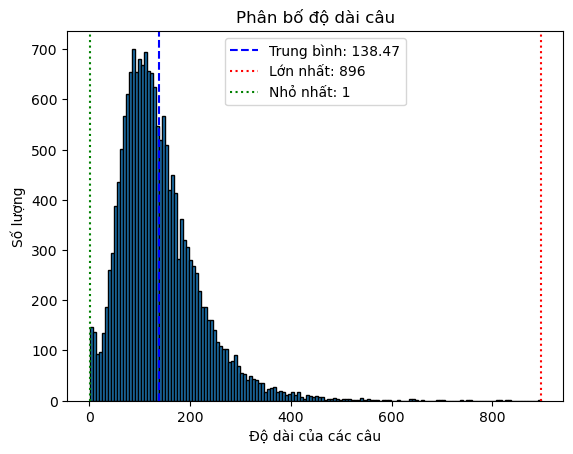

In [59]:
plt.hist(sentences_data_length, bins = 150, edgecolor = "black")
plt.title("Phân bố độ dài câu")
plt.xlabel("Độ dài của các câu")
plt.ylabel("Số lượng")
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1.5, label=f'Trung bình: {mean_value:.2f}')
plt.axvline(max_value, color='red', linestyle='dotted', linewidth=1.5, label=f'Lớn nhất: {max_value}')
plt.axvline(min_value, color='green', linestyle='dotted', linewidth=1.5, label=f'Nhỏ nhất: {min_value}')
plt.legend()
plt.savefig(r"D:\Tài liệu học đại học\Project1\Project-1\images\pic5678new.png", format="png", dpi=300)
plt.show()

In [18]:
sentences_data_new = [sentences_data[i] for i in range(len(sentences_data)) if len(sentences_data[i]) < 400]
print(f"Số phần tử của tập dữ liệu: {len(sentences_data_new)}")
sentences_data_length_new = [len(sentence) for sentence in sentences_data_new]

Số phần tử của tập dữ liệu: 17662


In [20]:
min_value = min(sentences_data_length_new)
max_value = max(sentences_data_length_new)
mean_value = sum(sentences_data_length_new) / len(sentences_data_new)

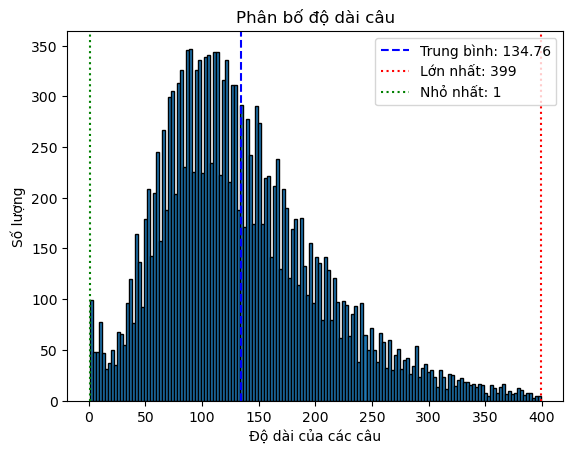

In [25]:
plt.hist(sentences_data_length_new, bins = 150, edgecolor = "black")
plt.title("Phân bố độ dài câu")
plt.xlabel("Độ dài của các câu")
plt.ylabel("Số lượng")
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=1.5, label=f'Trung bình: {mean_value:.2f}')
plt.axvline(max_value, color='red', linestyle='dotted', linewidth=1.5, label=f'Lớn nhất: {max_value}')
plt.axvline(min_value, color='green', linestyle='dotted', linewidth=1.5, label=f'Nhỏ nhất: {min_value}')
plt.legend()
plt.savefig(r"D:\Tài liệu học đại học\Project1\Project-1\images\pic5678.png", format="png", dpi=300)
plt.show()

###    **start_prob:** Xác suất để 1 từ là bắt đầu của một câu

    P(s) = (số lần câu bắt đầu bởi từ s) / (tổng số câu)
###   **trans_prob:** Xác suất để một từ xuất hiện sau một từ
    
    P(xt = s' | xt-1 = s) = (Số lần xuất hiện của cặp từ ss') / (Số lần xuất hiện của từ s)

### **emit_prob:** Xác suất phát sinh, xác suất để 1 từ có dấu tương ứng với từ không có dấu

    P(x = o | y = s) = (số lần từ không dấu s tương ứng từ có dấu o) / (Số lượng từ không dấu s)

In [78]:
def compute_probabilities(dataset):
  start_count = defaultdict(int)
  trans_count = defaultdict(lambda: defaultdict(int))
  emit_count = defaultdict(lambda: defaultdict(int))
  for sentence in tqdm(dataset):
    words = sentence.split()
    prev_word = None
    for idx, word in enumerate(words):
      no_diacritic = remove_diacritic(word)
      emit_count[no_diacritic][word] += 1
      if idx == 0:
        start_count[word] += 1
      else:
        trans_count[prev_word][word] += 1
      prev_word = word
    start_prob = {k : v / sum(start_count.values()) for k, v in start_count.items()}
    trans_prob = {k : {k2 : v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in trans_count.items()}
    emit_prob =  {k : {k2 : v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in emit_count.items()}
  return start_prob, trans_prob , emit_prob

In [79]:
states = defaultdict(list)

In [80]:
start_prob, trans_prob, emit_prob = compute_probabilities(sentences_data)

for word in emit_prob:
    states[remove_diacritic(word)].extend(emit_prob[word].keys())

100%|██████████| 17850/17850 [43:56<00:00,  6.77it/s]


In [82]:
print(emit_prob['Trang']['Trăng'])

0.2558139534883721


In [44]:
obs = "la mot to chuc hoat dong phi loi nhuan,"
result = beam_search(obs.split(" "), states, start_prob, trans_prob, emit_prob)
print("Chuỗi có dấu:", " ".join(result))

Chuỗi có dấu: là một tổ chức hoạt động phi lợi nhuận,


In [81]:
path = r'D:\Tài liệu học đại học\Project1\Project-1\probabilities.dill' 

with open(path, 'wb') as f:
    dill.dump((states, start_prob, trans_prob, emit_prob), f)

In [83]:
path = r'D:\Tài liệu học đại học\Project1\Project-1\probabilities.dill' 

with open(path, 'rb') as f:
    states, start_prob, trans_prob, emit_prob = dill.load(f)

In [71]:
print(states)

defaultdict(<class 'list'>, {'Trang': ['Trang', 'Tràng', 'Trăng', 'Tráng', 'Trạng', 'Trắng', 'Trảng'], 'Chinh': ['Chính', 'Chỉnh', 'Chinh'], 'Internet': ['Internet'], 'Society': ['Society'], 'hay': ['hay', 'hãy'], 'ISOC': ['ISOC'], 'la': ['là', 'la', 'lá', 'lạ'], 'mot': ['một', 'mọt'], 'to': ['tổ', 'tờ', 'tố', 'tỏ', 'tô', 'to', 'tộ', 'tò', 'tồ', 'tơ', 'tớ'], 'chuc': ['chức', 'chục', 'chúc'], 'quoc': ['quốc'], 'te': ['tế', 'tệ', 'tê', 'tẻ', 'tể', 'tễ'], 'hoat': ['hoạt', 'hoát'], 'dong': ['động', 'đồng', 'đóng', 'đông', 'dòng', 'đống', 'đọng', 'đổng', 'đong'], 'phi': ['phi', 'phí', 'phỉ', 'phì'], 'loi': ['lợi', 'lối', 'lỗi', 'lõi', 'lời', 'lội', 'lôi', 'lồi'], 'nhuan,': ['nhuận,'], 'chinh': ['chính', 'chỉnh', 'chinh'], 'phu': ['phủ', 'phụ', 'phú', 'phù', 'phu'], 'va': ['và', 'vã', 'vả', 'va', 'vá'], 'bao': ['bao', 'báo', 'bảo', 'bạo', 'bào', 'bão'], 'gom': ['gồm', 'gom', 'gớm', 'gốm'], 'cac': ['các'], 'thanh': ['thành', 'thanh', 'thánh'], 'vien': ['viên', 'viện', 'viễn', 'viền'], 'co': [

In [84]:
print(emit_prob['Trang']['Tràng'])

0.06976744186046512


In [85]:
obs = "la mot to chuc hoat dong phi loi nhuan,"
result = beam_search(obs.split(" "), states, start_prob, trans_prob, emit_prob)
print(result)
print("Chuỗi có dấu:", " ".join(result))

['la', 'một', 'tổ', 'chức', 'hoát', 'đông', 'phi', 'lợi', 'nhuận,']
Chuỗi có dấu: la một tổ chức hoát đông phi lợi nhuận,


In [30]:
print(sentences_data[:5])

['Trang Chính', 'Internet Society', 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận, phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành.', 'Tổ chức này chú trọng đến: tiêu chuẩn, giáo dục và các vấn đề về chính sách.', 'Với trên 145 tổ chức thành viên và 65.000 thành viên cá nhân, ISOC bao gồm những con người cụ thể trong cộng đồng Internet.']


In [86]:
random.seed(42)
test_data_1_result = random.sample(sentences_data, 1000)

In [87]:
test_data_1_result[:5]

['Rồi lại phải qua dãy núi lèn (đá không phá đất), đá đứng như tường, ở giữa có đường đi rất hiểm: đó là ải Giáp Khẩu, tức là ải Chi Lăng, ở phía bắc huyện Hữu Lũng thuộc Lạng Sơn ngày nay.',
 'Thành phố Hồ Chí Minh còn là một trung tâm mua sắm và giải trí.',
 'Trong 11 tháng đầu năm 2012, thành phố Huế đã nhận được 2,4 triệu lượt khách du lịch, tăng 24,6% so với cùng kỳ năm 2011.',
 'Bảng xếp hạng 100 phim Anh Quốc của BFI có "Monty Python\'s Life of Brian" (1979), phim này thường được công chúng Anh Quốc bình chọn là hài hước nhất mọi thời đại.',
 'Xấp xỉ 92% dân số toàn tỉnh cư trú trên đảo Newfoundland (cùng các đảo nhỏ xung quanh), trong đó hơn một nửa cư trú tại bán đảo Avalon.']

In [88]:
test_data_1 = [remove_diacritic(test_data_no_diacritic) for test_data_no_diacritic in test_data_1_result]
test_data_1[:5]

['Roi lai phai qua day nui len (da khong pha dat), da dung nhu tuong, o giua co duong di rat hiem: do la ai Giap Khau, tuc la ai Chi Lang, o phia bac huyen Huu Lung thuoc Lang Son ngay nay.',
 'Thanh pho Ho Chi Minh con la mot trung tam mua sam va giai tri.',
 'Trong 11 thang dau nam 2012, thanh pho Hue da nhan duoc 2,4 trieu luot khach du lich, tang 24,6% so voi cung ky nam 2011.',
 'Bang xep hang 100 phim Anh Quoc cua BFI co "Monty Python\'s Life of Brian" (1979), phim nay thuong duoc cong chung Anh Quoc binh chon la hai huoc nhat moi thoi dai.',
 'Xap xi 92% dan so toan tinh cu tru tren dao Newfoundland (cung cac dao nho xung quanh), trong do hon mot nua cu tru tai ban dao Avalon.']

In [90]:
def compare_words(sentence1, sentence2):
    words1 = sentence1.split()
    words2 = sentence2.split()
    same = 0
    for i in range(len(words1)):
        if words1[i] == words2[i]:
            same += 1
    similarity_prob = (same / len(words1)) * 100
    return similarity_prob

In [91]:
for test_data in test_data_1[:5]:
    test_data_diacritic = " ".join(beam_search(test_data.split(" "), states, start_prob, trans_prob, emit_prob))
    print(test_data_diacritic)

Rồi lại phải qua dãy núi lèn (đá không phá đất), đá đứng như tường, ở giữa có đường đi rất hiểm: đó là ải Giáp Khẩu, tức là ải Chi Lăng, ở phía bắc huyện Hữu Lũng thuộc Làng Sơn ngày này.
Thành phố Hồ Chí Minh con là một trung tâm mua sắm và giải trí.
Trong 11 tháng đầu năm 2012, thành phố Huệ đã nhận được 2,4 triệu lượt khách du lịch, tăng 24,6% so với cùng kỳ năm 2011.
Bảng xếp hạng 100 phim Anh Quốc của BFI có "Monty Python's Life of Brian" (1979), phim nay thường được công chúng Anh Quốc bình chọn là hài hước nhất mọi thời đãi.
Xấp xỉ 92% dân số toàn tỉnh cư trú trên đảo Newfoundland (cùng các đảo nhỏ xung quanh), trong do hơn một nửa cư trú tại bán đảo Avalon.


In [92]:
similarity_prob = 0
similarity_prob_list = []
for i in range(len(test_data_1)):
    test_data_diacritic = " ".join(beam_search(test_data_1[i].split(" "), states, start_prob, trans_prob, emit_prob))
    similarity_prob += compare_words(test_data_diacritic, test_data_1_result[i]) / len(test_data_1)
    similarity_prob_list.append(compare_words(test_data_diacritic, test_data_1_result[i]))


In [93]:
print(f"{similarity_prob:.2f}")

88.62


In [94]:
similarity_prob_list[:5]

[95.34883720930233,
 93.33333333333333,
 96.15384615384616,
 93.93939393939394,
 96.55172413793103]

In [95]:
prob_counts = Counter(similarity_prob_list)

In [96]:
print(f"Xác suất cao nhất: {max(similarity_prob_list)}")
print(f"Xác suất thấp nhất: {min(similarity_prob_list)}")
most_common_prob, frequency_prob_max = prob_counts.most_common(1)[0]
print(f"Xác suất xuất hiện nhiều nhất: {frequency_prob_max}")
least_common_prob, frequency_prob_min = prob_counts.most_common()[-1]
print(f"Xác suất xuất hiện ít nhất: {frequency_prob_min}")

Xác suất cao nhất: 100.0
Xác suất thấp nhất: 0.0
Xác suất xuất hiện nhiều nhất: 180
Xác suất xuất hiện ít nhất: 1


In [53]:
for i in range(len(similarity_prob_list)):
    if similarity_prob_list[i] == 0:
        print(test_data_1_result[i])
        print(test_data_1[i])

Thứ trưởng
Thu truong


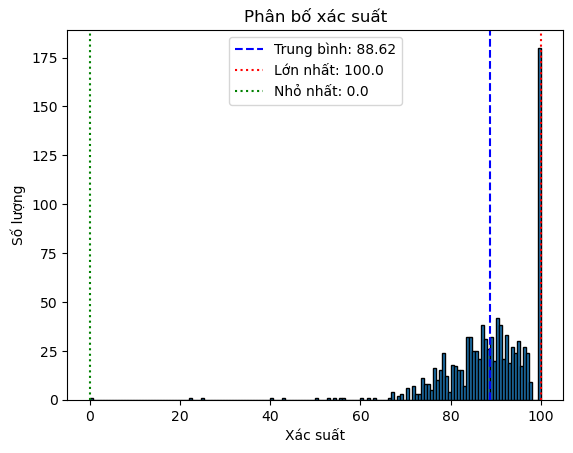

In [97]:
plt.hist(similarity_prob_list, bins = 150, edgecolor = "black")
plt.title("Phân bố xác suất")
plt.xlabel("Xác suất")
plt.ylabel("Số lượng")
plt.axvline(similarity_prob, color='blue', linestyle='dashed', linewidth=1.5, label=f'Trung bình: {similarity_prob:.2f}')
plt.axvline(max(similarity_prob_list), color='red', linestyle='dotted', linewidth=1.5, label=f'Lớn nhất: {max(similarity_prob_list)}')
plt.axvline(min(similarity_prob_list), color='green', linestyle='dotted', linewidth=1.5, label=f'Nhỏ nhất: {min(similarity_prob_list)}')
plt.legend()
plt.savefig(r"D:\Tài liệu học đại học\Project1\Project-1\images\result_HMM_pic5678.png", format="png", dpi=300)
plt.show()

In [98]:
random.seed(42)
test_data_2_result = random.sample(train_ipt_500k[10000:], 1000)

In [99]:
test_data_2_result

['Một hệ thống khác được phát triển bởi nhóm của Bruce Porter vào năm 1989 tại Đại học Texas là PROTOS, hệ thống này đã tích hợp thành công lập luận theo tri thức tổng quát ("general domain knowledge") và lập luận theo tình huống thể hiện trong một cấu trúc.\n',
 'Năm 1951, một trong những định nghĩa sớm nhất về "Nhà địa chất kỹ thuật" hay "chuyên gia địa chất kỹ thuật" được chính thức ra đời, cung cấp bởi Ủy ban điều hành của Phòng địa chất kỹ thuật của Hiệp hội địa chất Hoa Kỹ.\n',
 'Siemens qua đời tại Berlin năm 1892, di sản trực tiếp của ông là Công ty SIEMENS tiếp tục phát triển với những thành quả rực rỡ, liên tục cho ra đời những sản phẩm tiên tiến, cao siêu về mặt kỹ thuật. Các con trai và cháu của ông tiếp tục bước trên con đường nghiên cứu và kinh doanh, kế thừa một cách xuất sắc di sản mà người cha, người ông ngày xưa để lại.\n',
 'Việc đầu tiên Dracula làm là trả thù những kẻ đã giết cha và anh trai mình. Một ngày Chủ nhật đẹp trời năm 1459, Dracula cho bắt toàn bộ những n

In [100]:
test_data_2 = [remove_diacritic(test_data_no_diacritic) for test_data_no_diacritic in test_data_2_result]
test_data_2[:5]

['Mot he thong khac duoc phat trien boi nhom cua Bruce Porter vao nam 1989 tai Dai hoc Texas la PROTOS, he thong nay da tich hop thanh cong lap luan theo tri thuc tong quat ("general domain knowledge") va lap luan theo tinh huong the hien trong mot cau truc.\n',
 'Nam 1951, mot trong nhung dinh nghia som nhat ve "Nha dia chat ky thuat" hay "chuyen gia dia chat ky thuat" duoc chinh thuc ra doi, cung cap boi Uy ban dieu hanh cua Phong dia chat ky thuat cua Hiep hoi dia chat Hoa Ky.\n',
 'Siemens qua doi tai Berlin nam 1892, di san truc tiep cua ong la Cong ty SIEMENS tiep tuc phat trien voi nhung thanh qua ruc ro, lien tuc cho ra doi nhung san pham tien tien, cao sieu ve mat ky thuat. Cac con trai va chau cua ong tiep tuc buoc tren con duong nghien cuu va kinh doanh, ke thua mot cach xuat sac di san ma nguoi cha, nguoi ong ngay xua de lai.\n',
 'Viec dau tien Dracula lam la tra thu nhung ke da giet cha va anh trai minh. Mot ngay Chu nhat dep troi nam 1459, Dracula cho bat toan bo nhung n

In [101]:
similarity_prob1 = 0
similarity_prob_list1 = []
for i in range(len(test_data_1)):
    test_data_diacritic = " ".join(beam_search(test_data_2[i].split(" "), states, start_prob, trans_prob, emit_prob))
    similarity_prob1 += compare_words(test_data_diacritic, test_data_2_result[i]) / len(test_data_2)
    similarity_prob_list1.append(compare_words(test_data_diacritic, test_data_2_result[i]))


In [102]:
similarity_prob1

67.37196125856839

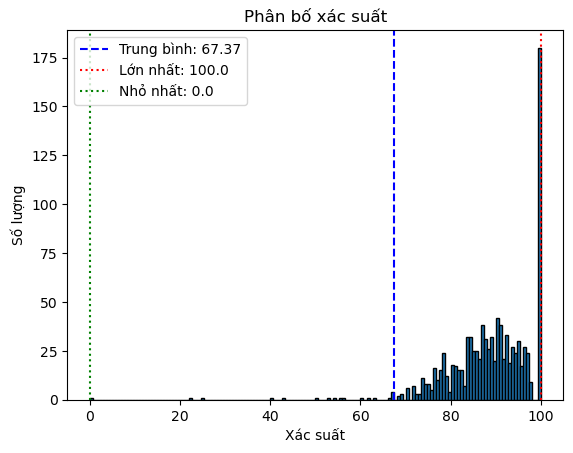

In [103]:
plt.hist(similarity_prob_list, bins = 150, edgecolor = "black")
plt.title("Phân bố xác suất")
plt.xlabel("Xác suất")
plt.ylabel("Số lượng")
plt.axvline(similarity_prob1, color='blue', linestyle='dashed', linewidth=1.5, label=f'Trung bình: {similarity_prob1:.2f}')
plt.axvline(max(similarity_prob_list1), color='red', linestyle='dotted', linewidth=1.5, label=f'Lớn nhất: {max(similarity_prob_list1)}')
plt.axvline(min(similarity_prob_list1), color='green', linestyle='dotted', linewidth=1.5, label=f'Nhỏ nhất: {min(similarity_prob_list1)}')
plt.legend()
plt.savefig(r"D:\Tài liệu học đại học\Project1\Project-1\images\result_1_HMM_pic5678.png", format="png", dpi=300)
plt.show()

In [104]:
dataset2 = train_ipt_500k[:10000]
sentences_data2 = [sent for sentence in dataset2 for sent in split_into_sentences(sentence)]
#remove_punctuation_corpus(dataset)
print(sentences_data2[:10])

['Trang Chính', 'Internet Society', 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận, phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành.', 'Tổ chức này chú trọng đến: tiêu chuẩn, giáo dục và các vấn đề về chính sách.', 'Với trên 145 tổ chức thành viên và 65.000 thành viên cá nhân, ISOC bao gồm những con người cụ thể trong cộng đồng Internet.', 'Mọi chi tiết có thể tìm thấy tại website của ISOC.', 'Internet Society nằm ở gần thủ đô Washington, DC, Hoa Kỳ và Geneva, Thụy Sĩ.', 'Số hội viên của nó bao gồm hơn 145 tổ chức thành viên và hơn 65.000 cá nhân.', 'Thành viên còn có thể tự lập một chi nhánh của tổ chức tùy theo vị trí hoặc sở thích.', 'Hiện nay tổ chức có tới 90 chi nhánh trên toàn thế giới.']


In [105]:
sentences_data_length2 = [len(sentence) for sentence in sentences_data2]
lengths_counts2 = Counter(sentences_data_length2)

In [106]:
print(f"Tổng số lượng câu là: {len(sentences_data2)}")
print(f"Độ dài trung bình của các câu: {sum(sentences_data_length2) / len(sentences_data2)}")
print(f"Độ dài câu dài nhất: {max(sentences_data_length2)}")
print(f"Độ dài câu ngắn nhất: {min(sentences_data_length2)}")
most_common_length2, frequency_max2 = lengths_counts2.most_common(1)[0]
print(f"Độ dài câu xuất hiện nhiều nhất: {frequency_max2}")
least_common_length2, frequency_min2 = lengths_counts2.most_common()[-1]
print(f"Độ dài câu xuất hiện ít nhất: {frequency_min2}")

Tổng số lượng câu là: 30607
Độ dài trung bình của các câu: 137.1210507400268
Độ dài câu dài nhất: 1123
Độ dài câu ngắn nhất: 1
Độ dài câu xuất hiện nhiều nhất: 227
Độ dài câu xuất hiện ít nhất: 1


In [109]:
min_value2 = min(sentences_data_length2)
max_value2 = max(sentences_data_length2)
mean_value2 = sum(sentences_data_length2) / len(sentences_data2)

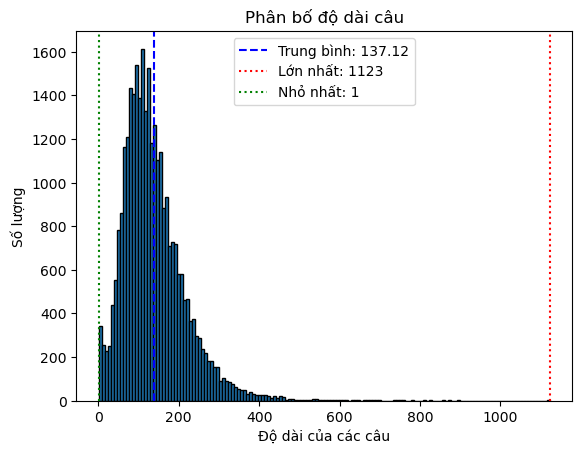

In [110]:
plt.hist(sentences_data_length2, bins = 150, edgecolor = "black")
plt.title("Phân bố độ dài câu")
plt.xlabel("Độ dài của các câu")
plt.ylabel("Số lượng")
plt.axvline(mean_value2, color='blue', linestyle='dashed', linewidth=1.5, label=f'Trung bình: {mean_value2:.2f}')
plt.axvline(max_value2, color='red', linestyle='dotted', linewidth=1.5, label=f'Lớn nhất: {max_value2}')
plt.axvline(min_value2, color='green', linestyle='dotted', linewidth=1.5, label=f'Nhỏ nhất: {min_value2}')
plt.legend()
plt.savefig(r"D:\Tài liệu học đại học\Project1\Project-1\images\pic10000new.png", format="png", dpi=300)
plt.show()

In [111]:
states2 = defaultdict(list)

In [112]:
start_prob2, trans_prob2, emit_prob2 = compute_probabilities(sentences_data2)

for word in emit_prob2:
    states2[remove_diacritic(word)].extend(emit_prob2[word].keys())


100%|██████████| 30607/30607 [2:18:09<00:00,  3.69it/s]  


In [114]:
path = r'probabilities2.dill'
with open(path, 'wb') as fa:
    dill.dump((states2, start_prob2, trans_prob2, emit_prob2), fa)

In [115]:
obs = "la mot to chuc hoat dong phi loi nhuan,"
result = beam_search(obs.split(" "), states2, start_prob2, trans_prob2, emit_prob2)
print(result)
print("Chuỗi có dấu:", " ".join(result))

['la', 'một', 'tổ', 'chức', 'hoạt', 'động', 'phi', 'lợi', 'nhuận,']
Chuỗi có dấu: la một tổ chức hoạt động phi lợi nhuận,


In [116]:
similarity_prob3 = 0
similarity_prob_list3 = []
for i in range(len(test_data_1)):
    test_data_diacritic = " ".join(beam_search(test_data_1[i].split(" "), states2, start_prob2, trans_prob2, emit_prob2))
    similarity_prob3 += compare_words(test_data_diacritic, test_data_1_result[i]) / len(test_data_1)
    similarity_prob_list3.append(compare_words(test_data_diacritic, test_data_1_result[i]))


In [117]:
similarity_prob3

87.37937198603407

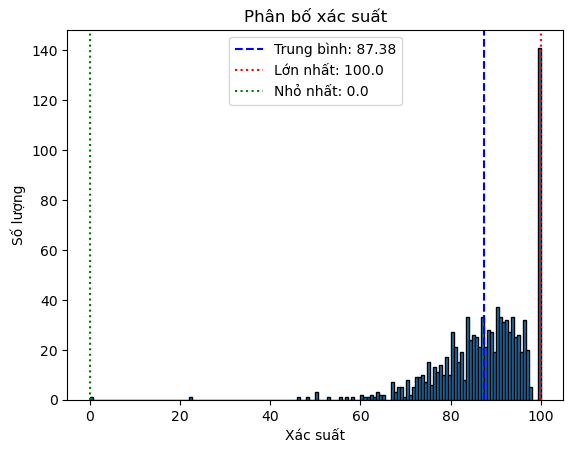

In [118]:
plt.hist(similarity_prob_list3, bins = 150, edgecolor = "black")
plt.title("Phân bố xác suất")
plt.xlabel("Xác suất")
plt.ylabel("Số lượng")
plt.axvline(similarity_prob3, color='blue', linestyle='dashed', linewidth=1.5, label=f'Trung bình: {similarity_prob3:.2f}')
plt.axvline(max(similarity_prob_list3), color='red', linestyle='dotted', linewidth=1.5, label=f'Lớn nhất: {max(similarity_prob_list3)}')
plt.axvline(min(similarity_prob_list3), color='green', linestyle='dotted', linewidth=1.5, label=f'Nhỏ nhất: {min(similarity_prob_list3)}')
plt.legend()
plt.savefig(r"D:\Tài liệu học đại học\Project1\Project-1\images\result_HMM_pic10000.png", format="png", dpi=300)
plt.show()

In [119]:
similarity_prob4 = 0
similarity_prob_list4 = []
for i in range(len(test_data_2)):
    test_data_diacritic = " ".join(beam_search(test_data_2[i].split(" "), states2, start_prob2, trans_prob2, emit_prob2))
    similarity_prob4 += compare_words(test_data_diacritic, test_data_2_result[i]) / len(test_data_2)
    similarity_prob_list4.append(compare_words(test_data_diacritic, test_data_2_result[i]))


In [120]:
similarity_prob4

68.05687635668035

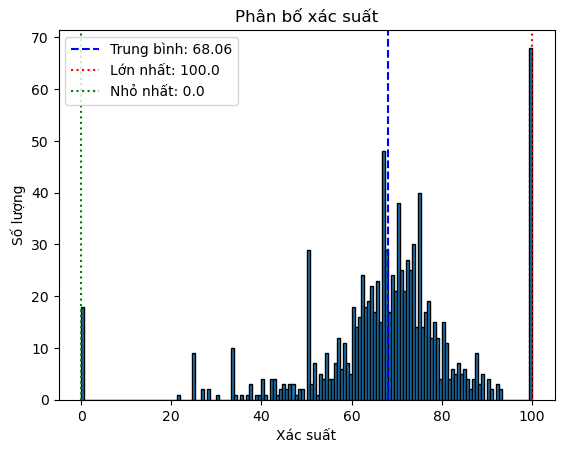

In [121]:
plt.hist(similarity_prob_list4, bins = 150, edgecolor = "black")
plt.title("Phân bố xác suất")
plt.xlabel("Xác suất")
plt.ylabel("Số lượng")
plt.axvline(similarity_prob4, color='blue', linestyle='dashed', linewidth=1.5, label=f'Trung bình: {similarity_prob4:.2f}')
plt.axvline(max(similarity_prob_list4), color='red', linestyle='dotted', linewidth=1.5, label=f'Lớn nhất: {max(similarity_prob_list4)}')
plt.axvline(min(similarity_prob_list4), color='green', linestyle='dotted', linewidth=1.5, label=f'Nhỏ nhất: {min(similarity_prob_list4)}')
plt.legend()
plt.savefig(r"D:\Tài liệu học đại học\Project1\Project-1\images\result_1_HMM_pic10000.png", format="png", dpi=300)
plt.show()